# Texture Synthesis with CNNs in PyTorch

<a href="https://colab.research.google.com/github/trsvchn/deep-textures/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uncomment if running from Colab
# !git clone https://github.com/trsvchn/deep-textures.git
# %cd deep-textures

Unofficial Reimplementation of **"Texture Synthesis Using Convolutional Neural Networks"** in PyTorch
(Gatys et al. 2015) (http://arxiv.org/abs/1505.07376)

In [2]:
import torch
import torch.optim as optim
from torchvision.transforms.functional import normalize

from PIL import Image
import matplotlib.pyplot as plt

from deeptextures import vgg19, gram_loss
from deeptextures.utils import set_seed, set_device, prep_img, to_pil, MEAN, STD

## Prepare Data

In [3]:
from io import BytesIO
from urllib.request import urlopen

# Get the example image from the official repo
IMG = "https://raw.githubusercontent.com/leongatys/DeepTextures/master/Images/pebbles.jpg"

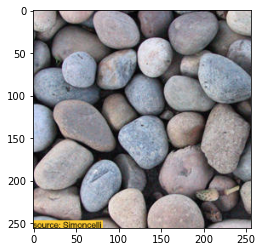

In [4]:
# Take a look
texture = Image.open(BytesIO(urlopen(IMG).read()))
plt.imshow(texture);

In [5]:
# Save it (uncomment to save)
texture.save("pebbles.jpg")

## Using LBFGS

0 3946302976.0


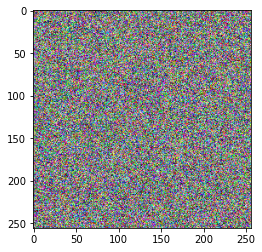

200 396546.625


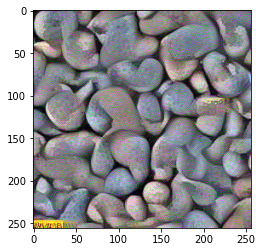

400 182930.28125


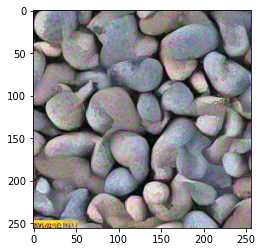

600 133061.046875


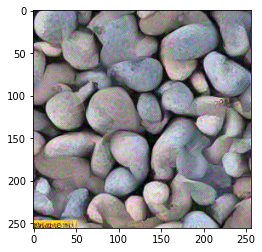

800 112995.5078125


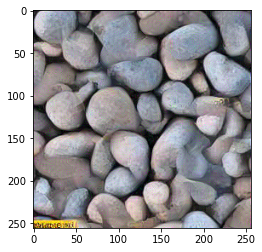

1000 103339.703125


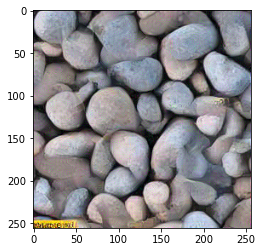

In [6]:
image = "pebbles.jpg"
img_size = 256
n_iters = 1000
layers = ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
layers_weigths = [1e9] * len(layers)
log_every = 200
seed = 0


# Set device and a seed
device = set_device()
set_seed(seed)

# Init model
model = vgg19().to(device)

# Prepare texture data
target = prep_img(image, img_size).to(device)

# Init input image
synth = torch.randint_like(target, 0, 256)
synth = synth.div(255)
synth = normalize(synth, MEAN, STD)
synth.requires_grad_(True)

# Set optimizer
optimizer = optim.LBFGS(
    [synth],
    tolerance_grad=0.0,
    tolerance_change=0.0,
    line_search_fn="strong_wolfe",
)

# Get feature maps for the target texture
target_activations = [*model(target, layers)]

iter_ = 0
while iter_ <= n_iters:

    def closure():
        global iter_

        optimizer.zero_grad()

        synth_activations = [*model(synth, layers)]

        assert len(synth_activations) == len(target_activations) == len(layers_weigths)
        
        # Compute loss for each activation
        losses = []
        for activations in zip(synth_activations, target_activations, layers_weigths):
            losses.append(gram_loss(*activations).unsqueeze(0))

        total_loss = torch.cat(losses).sum()
        total_loss.backward()

        if iter_ == 0 or iter_ % log_every == 0:
            # Print loss value
            print(iter_, total_loss.item())

            # Show image
            plt.imshow(to_pil(synth.squeeze(0)))
            plt.show()

        iter_ += 1

        return total_loss

    optimizer.step(closure)


# Save generated texture
to_pil(synth.squeeze()).save("pebbles_gen.png")

## Using Adam

1 3946302976.0


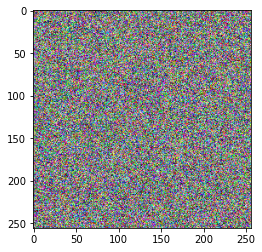

500 1445583.875


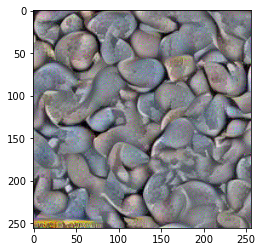

1000 652512.3125


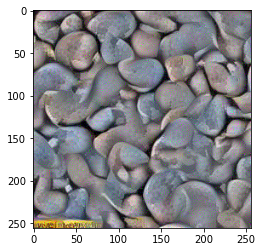

1500 430113.75


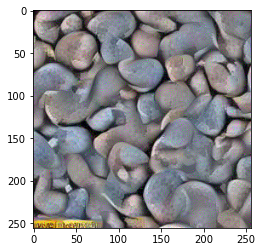

2000 334480.5


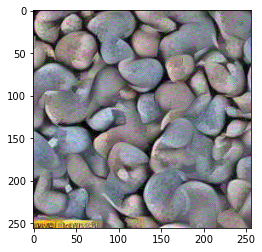

In [7]:
image = "pebbles.jpg"
img_size = 256
n_iters = 2000
layers = ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
layers_weigths = [1e9] * len(layers)
log_every = 500
seed = 0 

# Set device and a seed
device = set_device()
set_seed(seed)

# Init model
model = vgg19().to(device)

# Prepare texture data
target = prep_img(image, img_size).to(device)

# Init input image
synth = torch.randint_like(target, 0, 256)
synth = synth.div(255)
synth = normalize(synth, MEAN, STD)
synth.requires_grad_(True)

# Set optimizer
optimizer = optim.Adam([synth], lr=0.1)

# Get feature maps for the target texture
target_activations = [*model(target, layers)]

for iter_ in range(1, n_iters + 1):
    optimizer.zero_grad()

    synth_activations = [*model(synth, layers)]

    assert len(synth_activations) == len(target_activations) == len(layers_weigths)

    losses = []
    for activations in zip(synth_activations, target_activations, layers_weigths):
        losses.append(gram_loss(*activations).unsqueeze(0))

    total_loss = torch.cat(losses).sum()
    total_loss.backward()

    if iter_ == 1 or iter_ % log_every == 0:
        print(iter_, total_loss.item())
        plt.imshow(to_pil(synth.squeeze(0)))
        plt.show()

    optimizer.step()


to_pil(synth.squeeze()).save("pebbles_gen_adam.png")